# Predicting Energy Efficiency

# Hack and slash modeling of Airbnb listings data using the energy efficiency notebook from XBUS505

In [1]:
%matplotlib inline

import os
import requests
import pandas as pd 
import matplotlib.pyplot as plt

from pandas.tools.plotting import scatter_matrix

from sklearn import cross_validation as cv
from sklearn.cross_validation import train_test_split as tts

from sklearn.linear_model import Ridge
from sklearn.linear_model import RandomizedLasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

print (os.getcwd())

/Users/Devin/Repos/Georgetown/TZ


In [30]:
ENERGY = "listings_clean_headers_price_end_numeric.csv"

print (os.getcwd())

/Users/Devin/Repos/Georgetown/TZ


In [3]:
def download_data(url, path='data'):
    if not os.path.exists(path):
        os.mkdir(path)

    response = requests.get(url)
    name = os.path.basename(url)
    with open(os.path.join(path, name), 'w') as f:
        f.write(response.content)

In [4]:
download_data(ENERGY)

MissingSchema: Invalid URL 'listings_clean_headers.csv': No schema supplied. Perhaps you meant http://listings_clean_headers.csv?

In [31]:
energy   = pd.read_csv('listings_clean_headers_price_end_numeric.csv', sep=",")

In [33]:
energy.head()

,id,host_id,host_response_rate,host_acceptance_rate,host_listings_count,zipcode,latitude,longitude,accommodates,bathrooms,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,price
0,7087327,15830506,0.92,0.91,26,20003,38.890046,-77.002808,4,1.0,...,0,0,0,0,0,0,0,0,0.00,160
1,975833,5338703,0.90,1.00,1,20003,38.880413,-76.990485,6,3.0,...,65,94,10,9,10,10,9,9,2.11,350
2,8249488,1487418,0.90,1.00,2,20782,38.955291,-76.986006,1,2.0,...,1,0,0,0,0,0,0,0,1.00,50
3,8409022,16970249,1.00,0.00,1,20024,38.872134,-77.019639,2,1.0,...,0,0,0,0,0,0,0,0,0.00,95
4,8411173,30369828,0.92,0.67,1,20910,38.996382,-77.041541,4,1.0,...,0,0,0,0,0,0,0,0,0.00,50


In [37]:
energy.columns = [
    'id',\
    'host_id',\
    'host_response_rate',\
    'host_acceptance_rate',\
    'host_listings_count',\
    'zipcode',\
    'latitude',\
    'longitude',\
    'accommodates',\
    'bathrooms',\
    'bedrooms',\
    'beds',\
    'square_feet',\
    'weekly_price',\
    'monthly_price',\
    'security_deposit',\
    'cleaning_fee',\
    'guests_included',\
    'extra_people',\
    'minimum_nights',\
    'maximum_nights',\
    'availability_30',\
    'availability_60',\
    'availability_90',\
    'availability_365',\
    'number_of_reviews',\
    'review_scores_rating',\
    'review_scores_accuracy',\
    'review_scores_cleanliness',\
    'review_scores_checkin',\
    'review_scores_communication',\
    'review_scores_location',\
    'review_scores_value',\
    'reviews_per_month',\
    'price'\
]



In [38]:
energy.describe()

,id,host_id,host_response_rate,host_acceptance_rate,host_listings_count,zipcode,latitude,longitude,accommodates,bathrooms,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,price
count,3.273000e+03,3.273000e+03,3273.000000,3273.000000,3273.000000,3273.000000,3273.000000,3273.000000,3273.000000,3273.000000,...,3273.000000,3273.000000,3273.000000,3273.000000,3273.000000,3273.000000,3273.000000,3273.000000,3273.000000,3273.000000
mean,4.801764e+06,1.492869e+07,0.805619,0.720339,14.765964,19973.882371,38.915856,-77.024826,3.164070,1.244424,...,14.927284,71.509624,7.299725,7.125267,7.428048,7.470822,7.165597,7.130461,1.393954,147.601283
std,2.652907e+06,1.359391e+07,0.325403,0.373541,68.636165,928.595793,0.021070,0.025119,2.015594,0.588308,...,29.241808,39.986374,4.092190,4.050214,4.150784,4.155499,4.032275,4.002875,1.726067,137.199446
min,3.192000e+03,1.585000e+03,0.000000,0.000000,1.000000,0.000000,38.825061,-77.110525,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000
25%,2.478422e+06,3.202819e+06,0.800000,0.520000,1.000000,20002.000000,38.904994,-77.039755,2.000000,1.000000,...,1.000000,73.000000,8.000000,6.000000,8.000000,8.000000,7.000000,7.000000,0.120000,85.000000
50%,5.030319e+06,1.036467e+07,0.990000,0.920000,1.000000,20009.000000,38.914122,-77.028146,2.000000,1.000000,...,4.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.810000,115.000000
75%,7.159001e+06,2.442138e+07,1.000000,1.000000,3.000000,20011.000000,38.926989,-77.011267,4.000000,1.000000,...,16.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,160.000000
max,8.688457e+06,4.555465e+07,1.000000,1.000000,480.000000,22209.000000,38.996382,-76.913137,16.000000,8.000000,...,362.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.980000,2822.000000


## Are the features predictive?

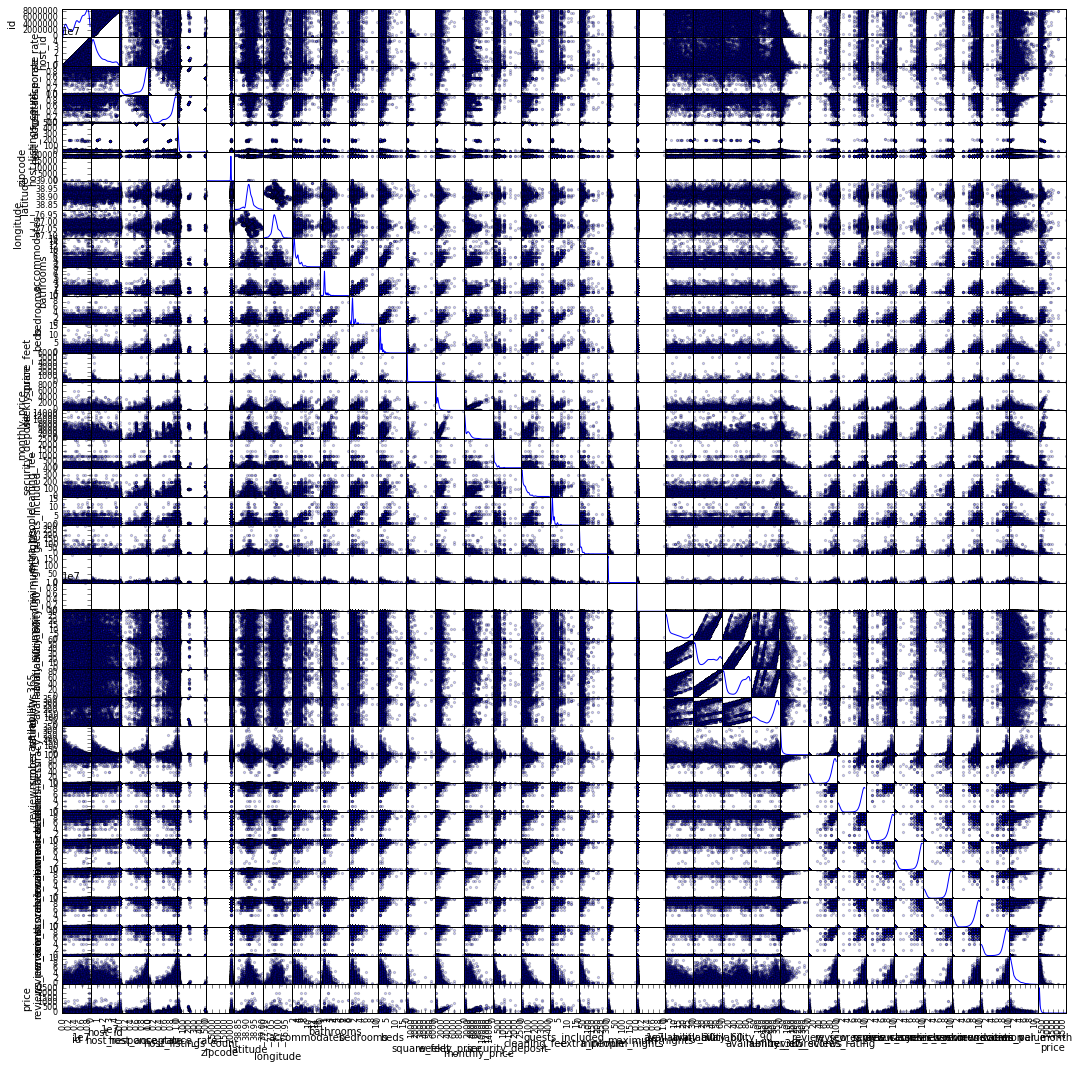

In [50]:
scatter_matrix(energy, alpha=0.2, figsize=(18,18), diagonal='kde')
plt.show()

In [40]:
energy_features = energy.ix[:,0:34]
energy_labels = energy.ix[:,34:]



In [41]:
model = RandomizedLasso(alpha=0.1)
model.fit(energy_features, energy_labels["price"])
names = list(energy_features)

print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), model.scores_), 
                 names), reverse=True)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/linear_model/randomized_l1.py:53: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  for _ in range(n_resampling)):
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/linear_model/randomized_l1.py:53: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  for _ in range(n_resampling)):
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/linear_model/randomized_l1.py:53: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  for _ in range(n_resampling)):
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/linear_model/randomized_l1.py:53: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  for _ in range(n_resampling)):
/Library/Frameworks/Python.framework/Ver

Features sorted by their score:
[(1.0, 'host_listings_count'), (1.0, 'bathrooms'), (0.99, 'bedrooms'), (0.985, 'accommodates'), (0.805, 'weekly_price'), (0.77, 'host_response_rate'), (0.65, 'host_acceptance_rate'), (0.645, 'monthly_price'), (0.515, 'latitude'), (0.505, 'cleaning_fee'), (0.485, 'security_deposit'), (0.475, 'beds'), (0.455, 'review_scores_communication'), (0.45, 'longitude'), (0.445, 'reviews_per_month'), (0.365, 'square_feet'), (0.345, 'host_id'), (0.255, 'review_scores_checkin'), (0.235, 'review_scores_value'), (0.235, 'guests_included'), (0.185, 'availability_365'), (0.18, 'review_scores_accuracy'), (0.175, 'availability_30'), (0.06, 'extra_people'), (0.02, 'review_scores_cleanliness'), (0.01, 'review_scores_rating'), (0.01, 'review_scores_location'), (0.0, 'zipcode'), (0.0, 'number_of_reviews'), (0.0, 'minimum_nights'), (0.0, 'maximum_nights'), (0.0, 'id'), (0.0, 'availability_90'), (0.0, 'availability_60')]


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/linear_model/randomized_l1.py:53: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  for _ in range(n_resampling)):
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/linear_model/randomized_l1.py:53: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  for _ in range(n_resampling)):
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/linear_model/randomized_l1.py:53: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  for _ in range(n_resampling)):
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/linear_model/randomized_l1.py:53: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  for _ in range(n_resampling)):


In [ ]:
model = RandomizedLasso(alpha=0.1)
model.fit(energy_features, energy_labels["cooling_load"])
names = list(energy_features)

print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), model.scores_), 
                 names), reverse=True)

## Let's focus on predicting heating load

In [43]:
heat_labels = energy.ix[:,34]

In [44]:
splits = cv.train_test_split(energy_features, heat_labels, test_size=0.2)
X_train, X_test, y_train, y_test = splits

In [49]:
model = Ridge(alpha=0.1)
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print "Ridge Regression model"
print "Mean Squared Error: %0.3f" % mse(expected, predicted)
print "Coefficient of Determination: %0.3f" % r2_score(expected, predicted)
print "R2 score = %0.3f" % r2_score(expected, predicted)

Ridge Regression model
Mean Squared Error: 10039.127
Coefficient of Determination: 0.397
R2 score = 0.397


In [48]:
model = LinearRegression()
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print "Linear Regression model"
print "Mean Squared Error: %0.3f" % mse(expected, predicted)
print "Coefficient of Determination: %0.3f" % r2_score(expected, predicted)
print "R2 score = %0.3f" % r2_score(expected, predicted)

Linear Regression model
Mean Squared Error: 10030.109
Coefficient of Determination: 0.398
R2 score = 0.398


In [47]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print "Random Forest model"
print "Mean squared error = %0.3f" % mse(expected, predicted)
print "R2 score = %0.3f" % r2_score(expected, predicted)

Random Forest model
Mean squared error = 6950.543
R2 score = 0.582


## Which one did best? 

## What should we try next?

## Ready for a bigger challenge? Try this one!

Build a command line application to compute the energy efficiency of a house     
https://github.com/georgetown-analytics/machine-learning/blob/master/code/energy.py